# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
import tensorflow as tf

print("TF version:", tf.__version__)
print("Dispositivos:", tf.config.list_physical_devices())
print("GPUs (tipo GPU):", tf.config.list_physical_devices("GPU"))


TF version: 2.10.0
Dispositivos: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs (tipo GPU): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import h5py

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras import layers, models
import keras.backend as K


## Model Choice

As a baseline model, we implement the reference architecture provided in the challenge description:  
a **3-layer 1D Convolutional Neural Network** consisting of:

- Two convolution + max-pool blocks (each pooling with factor 10),
- One final convolution layer producing a 1 Hz probability sequence (90 values per window).

This baseline is appropriate because:

1. It is the *official benchmark model* of the challenge.  
2. It directly processes raw PSG data at 100 Hz without handcrafted features.  
3. It produces a segmentation mask at 1 Hz that aligns with the provided ground-truth labels.  
4. It provides a fair starting point for assessing more advanced models later.

This model does not incorporate temporal recurrence or attention; it is intentionally simple.



## Feature Selection

Each training example contains:

- **8 PSG channels**, sampled at **100 Hz**, giving a tensor of shape `(9000, 8)` for each 90-second window.
- **A segmentation mask** of shape `(90,)`, sampled at 1 Hz.

For this baseline, we directly feed the raw 8-channel signals to the CNN.  
No feature engineering is performed.

The subject identity for each window is provided separately in the file
`X_train_h7ipJUo.csv`, which is used only to perform a **subject-wise train/validation split**
to avoid data leakage between train and validation sets.


In [3]:
#load X from H5 file
input_path = r"C:\Users\giuli\Documents\Open_Campus\Sleep_Apnea\00_pre files\X_normalized.h5"
with h5py.File(input_path, "r") as f:
    X = f["data"][:]  # Load the dataset into a NumPy array

X = X.astype("float32")

# print shape of X
print("X shape:", X.shape)

X shape: (4400, 9000, 8)


In [4]:
# Load subject metadata
meta = pd.read_csv(r"C:\Users\giuli\Documents\Open_Campus\Sleep_Apnea\00_pre files\X_train_h7ipJUo.csv")    # contains subject IDs
print(meta.head())

subject_ids = meta["Subject_ID"].to_numpy()

# Load y CSV file
y_path = r"C:\Users\giuli\Documents\Open_Campus\Sleep_Apnea\00_pre files\y_train_tX9Br0C.csv"


y_df = pd.read_csv(y_path)

# Save ID separately if needed for alignment or merging
y_id = y_df["ID"].to_numpy()

# Keep only mask columns
mask_cols = [c for c in y_df.columns if c.startswith("y_")]

y = y_df[mask_cols].to_numpy()
# Convert y to float32
y = y.astype("float32")




print("y shape:", y.shape)
print("Subjects shape:", subject_ids.shape)


    ID  Subject_ID
0  0.0         0.0
1  1.0         0.0
2  2.0         0.0
3  3.0         0.0
4  4.0         0.0
y shape: (4400, 90)
Subjects shape: (4400,)


In [5]:
# data types
#X = X.astype("float32")
#y = y.astype("float32")
print("X dtype:", X.dtype)
print("y dtype:", y.dtype)
print("subject_ids dtype:", subject_ids.dtype)

X dtype: float32
y dtype: float32
subject_ids dtype: float64


Subject-wise Train/Validation Split

In [6]:
def train_val_split_by_subject(X, y, subject_ids, train_ratio=0.7, seed=42):
    rng = np.random.default_rng(seed)

    unique_subj = np.unique(subject_ids)
    rng.shuffle(unique_subj)

    n_train = int(len(unique_subj) * train_ratio)
    train_subj = unique_subj[:n_train]

    train_mask = np.isin(subject_ids, train_subj)
    val_mask   = ~train_mask

    return X[train_mask], X[val_mask], y[train_mask], y[val_mask], train_subj


X_train, X_val, y_train, y_val, train_subjects = train_val_split_by_subject(
    X, y, subject_ids, train_ratio=0.7, seed=42
)

print("Train windows:", X_train.shape)
print("Val windows:", X_val.shape)
print("Train subjects:", train_subjects)
print("Number of train subjects:", len(train_subjects))
print("Validation subjects:", np.unique(subject_ids[~np.isin(subject_ids, train_subjects)]))


Train windows: (3000, 9000, 8)
Val windows: (1400, 9000, 8)
Train subjects: [17. 10. 16. 21. 12. 15.  7.  6.  9.  3.  0. 18.  5. 11. 14.]
Number of train subjects: 15
Validation subjects: [ 1.  2.  4.  8. 13. 19. 20.]


In [7]:
# types

print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
print("X_val dtype:", X_val.dtype)
print("y_val dtype:", y_val.dtype)

X_train dtype: float32
y_train dtype: float32
X_val dtype: float32
y_val dtype: float32


## Implementation

Below we implement the 3-layer CNN baseline as specified by the challenge.
Two Conv1D + MaxPool1D blocks downsample the 100 Hz signal to 1 Hz, and the final
Conv1D layer outputs class probabilities for each of the 90 seconds.


In [8]:
FS = 100
WINDOW_SECONDS = 90
N_SAMPLES = FS * WINDOW_SECONDS  # 9000
N_CHANNELS = 8

def build_baseline_cnn():
    model = models.Sequential([
        layers.Input(shape=(N_SAMPLES, N_CHANNELS)),

        layers.Conv1D(32, kernel_size=25, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=10),  # 9000 → 900

        layers.Conv1D(64, kernel_size=25, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=10),  # 900 → 90

        layers.Conv1D(1, kernel_size=3, padding='same', activation='sigmoid'),
        layers.Lambda(lambda t: tf.squeeze(t, axis=-1))  # (batch, 90)
    ])
    return model

model = build_baseline_cnn()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9000, 32)          6432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 900, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 900, 64)           51264     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 90, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 90, 1)             193       
                                                                 
 lambda (Lambda)             (None, 90)                0

In [9]:
positive_ratio = np.mean(y)     # % of 1s
neg_ratio = 1 - positive_ratio

pos_weight = neg_ratio / positive_ratio
print("Positive class weight:", pos_weight)


Positive class weight: 13.551333130451082


In [10]:
def weighted_bce(pos_weight):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weight = 1 + (pos_weight - 1) * y_true
        return K.mean(bce * weight)
    return loss


In [ ]:
lr = 1e-6
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'],
    loss=weighted_bce(pos_weight=pos_weight)
)

In [31]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="C:\\Users\\giuli\\Documents\\Open_Campus\\Sleep_Apnea\\2_BaselineModel\\baseline_lr1e-6.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    ),
    #tf.keras.callbacks.ReduceLROnPlateau(
    #monitor='val_loss',
    #factor=0.3,       # divide LR por 2 quando não melhora
    #patience=3,       # espera 3 epochs sem melhora
    #min_lr=1e-6
    #)
]

In [32]:
baseline = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 1.2296 - accuracy: 0.0023
Epoch 1: val_loss improved from inf to 1.43337, saving model to C:\Users\giuli\Documents\Open_Campus\Sleep_Apnea\2_BaselineModel\baseline_lr1e-6.keras
94/94 [==============================] - 14s 147ms/step - loss: 1.2296 - accuracy: 0.0023 - val_loss: 1.4334 - val_accuracy: 0.0000e+00
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 1.2296 - accuracy: 0.0020
Epoch 2: val_loss did not improve from 1.43337
94/94 [==============================] - 13s 133ms/step - loss: 1.2296 - accuracy: 0.0020 - val_loss: 1.4335 - val_accuracy: 0.0000e+00
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 1.2295 - accuracy: 0.0023
Epoch 3: val_loss did not improve from 1.43337
94/94 [==============================] - 13s 138ms/step - loss: 1.2295 - accuracy: 0.0023 - val_loss: 1.4336 - val_accuracy: 0.0000e+00
Epoch 4/100
94/94 [==============================] - ETA: 0s -

## Evaluation

To establish a simple numerical baseline, we evaluate the model at the *window level* by
thresholding the predicted 1-Hz mask and assessing standard binary classification metrics:

- Accuracy
- Precision
- Recall
- F1-score

For this baseline notebook, we evaluate whether the window contains at least one apnea event.
The official challenge evaluation (event-level F1 with IoU)



In [34]:
# Convert 90-second masks into a binary window label: apnea yes/no
y_true_window = (y_val.max(axis=1) > 0).astype(int)

# Predict mask
y_pred_mask = model.predict(X_val)
y_pred_window = (y_pred_mask.max(axis=1) > 0.5).astype(int)

print(classification_report(y_true_window, y_pred_window, target_names=["no_apnea", "apnea"]))
print("Confusion matrix:")
print(confusion_matrix(y_true_window, y_pred_window))



44/44 [==============================] - 2s 48ms/step
              precision    recall  f1-score   support

    no_apnea       0.82      0.93      0.87      1078
       apnea       0.58      0.34      0.43       322

    accuracy                           0.79      1400
   macro avg       0.70      0.63      0.65      1400
weighted avg       0.77      0.79      0.77      1400

Confusion matrix:
[[999  79]
 [213 109]]


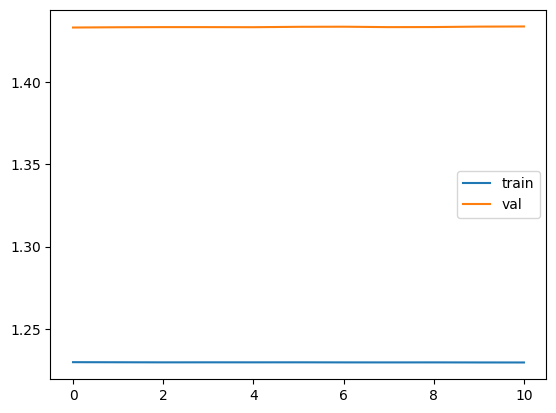

In [36]:
import matplotlib.pyplot as plt

plt.plot(baseline.history["loss"], label="train")
plt.plot(baseline.history["val_loss"], label="val")
plt.legend()
plt.show()


In [37]:

# per-window true labels
y_true_window = (y_val.max(axis=1) > 0).astype(int)

y_pred_mask = model.predict(X_val)           # (N, 90)
window_scores = y_pred_mask.max(axis=1)      # (N,)

best_t = None
best_f1 = -1

for t in np.linspace(0.05, 0.5, 20):
    y_pred_window = (window_scores >= t).astype(int)
    f1 = f1_score(y_true_window, y_pred_window, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold:", best_t)
print("Best window-level F1:", best_f1)


44/44 [==============================] - 2s 49ms/step
Best threshold: 0.5
Best window-level F1: 0.42745098039215684


In [38]:
y_pred_mask = model.predict(X_val)

print("min:", y_pred_mask.min())
print("max:", y_pred_mask.max())
print("mean:", y_pred_mask.mean())


44/44 [==============================] - 2s 57ms/step
min: 0.012652578
max: 0.7973592
mean: 0.47291118


In [2]:
test_file_path = r"C:\Users\giuli\Documents\Open_Campus\Sleep_Apnea\00_pre files\X_test_normalized.h5"

with h5py.File(test_file_path, "r") as f:
    raw = f["data"][:]              

# to np array of float32
    X_test = raw.astype("float32")

# shape of X_test
    print("X_test shape:", X_test.shape)    


X_test shape: (4400, 9000, 8)


In [5]:
import keras
baseline = keras.models.load_model(
    r"C:\Users\giuli\Documents\Open_Campus\Sleep_Apnea\2_BaselineModel\baseline_lr1e-6.keras",
    compile=False
)

# Agora você pode fazer:
y_pred = baseline.predict(X_test)



138/138 [==============================] - 3s 20ms/step


In [ ]:
# normalize predictions to CSV with id columns  
output_df = pd.DataFrame(y_pred, columns=[f"y_{i}" for i in range(y_pred.shape[1])])
output_df.to_csv

In [ ]:
#save predictions to CSV with id columns

output_df = pd.DataFrame(y_pred, columns=[f"y_{i}" for i in range(y_pred.shape[1])])
output_df.to_csv(r"C:\Users\giuli\Documents\Open_Campus\Sleep_Apnea\2_BaselineModel\y_test_predictions.csv", index=False)

In [13]:
test_file_path = r"C:\Users\giuli\Documents\Open_Campus\Sleep_Apnea\00_pre files\X_test.h5"

with h5py.File(test_file_path, "r") as f:
    raw = f["data"][:]              # shape: (4400, 72002)

# 1) metadata
ids      = raw[:, 0].astype(int)    # window ID


print("First 10 IDs:     ", ids[:10])

import pandas as pd

# escolha um threshold
thr = 0.495
df_bin = (output_df >= thr).astype(int)

# adiciona ID na primeira coluna
df_submission = df_bin.copy()
df_submission.insert(0, "ID", ids)

df_submission.to_csv("submission_final.csv", index=False)





First 10 IDs:      [4400 4401 4402 4403 4404 4405 4406 4407 4408 4409]
